In [2]:
# 주식 종목 불러오는 패키지
!pip install finance-datareader

In [3]:
import FinanceDataReader as fdr

In [10]:
# 삼성전자로 세팅됨, 종목번호 및 기간 바꿔서 진행
df = fdr.DataReader('064820', '2022-09-14', '2024-12-13')
df.tail

<bound method NDFrame.tail of             Open  High   Low  Close  Volume    Change
Date                                                 
2022-09-14  4800  4970  4800   4925   79092 -0.010050
2022-09-15  4950  5100  4950   5100  133272  0.035533
2022-09-16  5090  5130  4965   4995  117536 -0.020588
2022-09-19  5020  5020  4870   4885   89087 -0.022022
2022-09-20  4840  5000  4840   4915   14432  0.006141
...          ...   ...   ...    ...     ...       ...
2024-01-18  4160  4220  4025   4060  224989 -0.014563
2024-01-19  4105  4120  4005   4100   42120  0.009852
2024-01-22  4035  4145  4035   4090   13623 -0.002439
2024-01-23  4070  4250  4070   4230   60305  0.034230
2024-01-24  4200  4230  4130   4135   43770 -0.022459

[337 rows x 6 columns]>

In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# GPU 꼭 연결해서 사용하세요~!
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

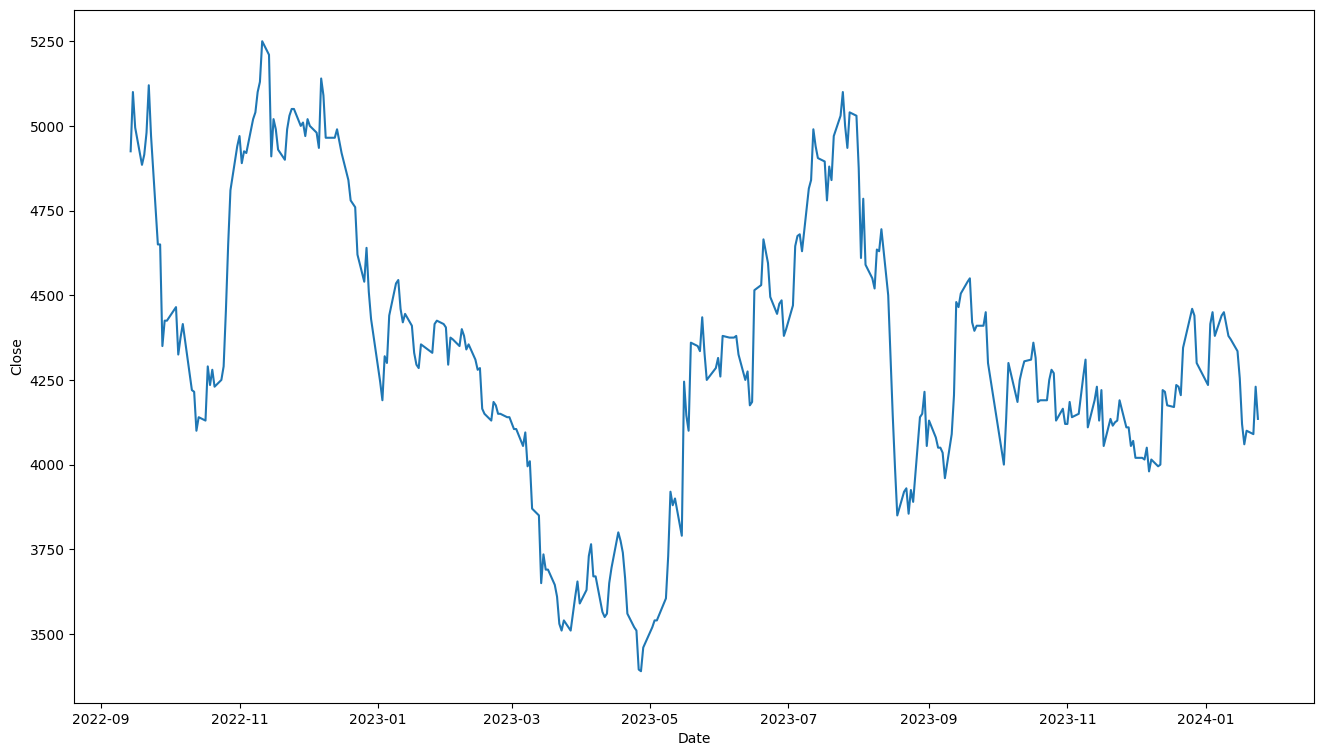

In [12]:
plt.figure(figsize=(16, 9))
sns.lineplot(x=df.index, y='Close', data=df)
plt.show()
#주식 그래프

# 데이터 전처리

In [13]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Change'], dtype='object')

In [14]:
#종가 제외 스케일링 (예측변수 = 종가)
scaler = MinMaxScaler()
df[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(df[['Open','High', 'Low','Close','Volume']])

In [15]:
#넘파이 배열로 변경
x = df[['Open', 'High', 'Low', 'Volume']].values
y = df['Close'].values

#시퀀스 데이터 생성
def seq_data(x, y, sequence_length):
  x_seq = []
  y_seq = []
  for i in range(len(x) - sequence_length):
    x_seq.append(x[ i : i + sequence_length])
    y_seq.append(y[i + sequence_length])

  #gpu용 텐서로 변환
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)

In [17]:
split = 210
sequence_length=5 # 5일치씩 묶기
x_seq, y_seq = seq_data(x, y, sequence_length) #x, y를 sequence_length 길이로 지정

#순서대로 210개는 학습, 나머지는 평가
x_train_seq = x_seq[:split] #split 개수까지 train
y_train_seq = y_seq[:split]

x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]

print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

torch.Size([210, 5, 4]) torch.Size([210, 1])
torch.Size([122, 5, 4]) torch.Size([122, 1])


In [18]:
x_train_seq

tensor([[[0.7622, 0.8177, 0.7984, 0.0266],
         [0.8432, 0.8854, 0.8780, 0.0465],
         [0.9189, 0.9010, 0.8859, 0.0407],
         [0.8811, 0.8438, 0.8355, 0.0303],
         [0.7838, 0.8333, 0.8196, 0.0029]],

        [[0.8432, 0.8854, 0.8780, 0.0465],
         [0.9189, 0.9010, 0.8859, 0.0407],
         [0.8811, 0.8438, 0.8355, 0.0303],
         [0.7838, 0.8333, 0.8196, 0.0029],
         [0.8595, 0.8438, 0.8568, 0.0356]],

        [[0.9189, 0.9010, 0.8859, 0.0407],
         [0.8811, 0.8438, 0.8355, 0.0303],
         [0.7838, 0.8333, 0.8196, 0.0029],
         [0.8595, 0.8438, 0.8568, 0.0356],
         [0.8405, 0.9531, 0.8488, 0.1592]],

        ...,

        [[0.8243, 0.7943, 0.7878, 0.0294],
         [0.7892, 0.7812, 0.8037, 0.0166],
         [0.8135, 0.8073, 0.7878, 0.0220],
         [0.7297, 0.8333, 0.7374, 0.0345],
         [0.7919, 0.8125, 0.7984, 0.0451]],

        [[0.7892, 0.7812, 0.8037, 0.0166],
         [0.8135, 0.8073, 0.7878, 0.0220],
         [0.7297, 0.8333, 0.7374

In [19]:
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 5
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size = batch_size)

# Vanila RNN
## 모델 구축

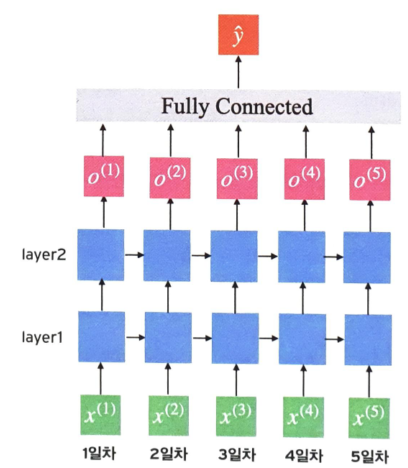

In [20]:
#기본 하이퍼 파라미터 설정
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [21]:
class VanillaRNN(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(VanillaRNN, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True) #한 줄로 모델 정의
    self.fc = nn.Sequential(nn.Linear(hidden_size * sequence_length, 1), nn.Sigmoid()) #RNN 층에서 나온 결과를 fc 층으로 전달해서 예측값 계산

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) #초기값 0으로 설정
    out,_ = self.rnn(x, h0)
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

In [22]:
model = VanillaRNN(input_size=input_size,
                   hidden_size = hidden_size,
                   sequence_length=sequence_length,
                   num_layers=num_layers,
                   device=device).to(device)

In [23]:
criterion = nn.MSELoss()
num_epochs = 50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## 모델 학습

In [24]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
  running_loss = 0

  for data in train_loader:
    seq, target = data #배치 데이터
    out = model(seq) #출력값 계산
    loss = criterion(out, target) #손실함수 계산

    optimizer.zero_grad()
    loss.backward()
    optimizer.step() #최적화
    running_loss += loss.item()

  loss_graph.append(running_loss/n)
  if epoch % 10 ==0:
    print('[epoch : %d] loss: %.4f' %(epoch, running_loss/n))

[epoch : 0] loss: 0.0657
[epoch : 10] loss: 0.0089
[epoch : 20] loss: 0.0068
[epoch : 30] loss: 0.0057
[epoch : 40] loss: 0.0048


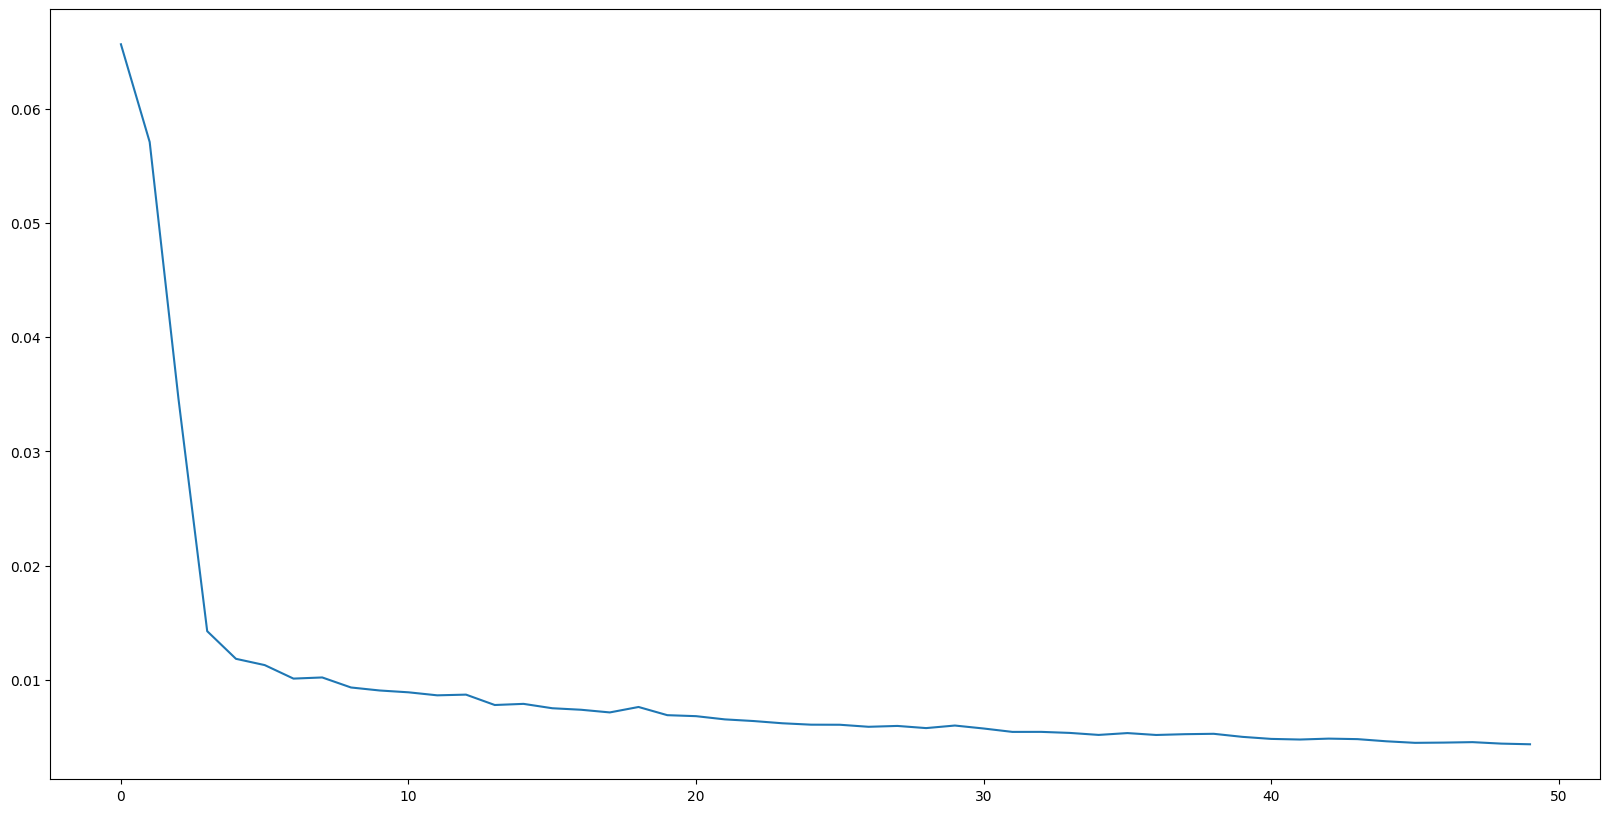

In [25]:
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()

## 실제값과 예측값 비교

In [26]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset = concatdata, batch_size = 100)

with torch.no_grad():
  pred = []
  model.eval()
  for data in data_loader:
    seq, target = data
    out = model(seq)
    pred += out.cpu().tolist()

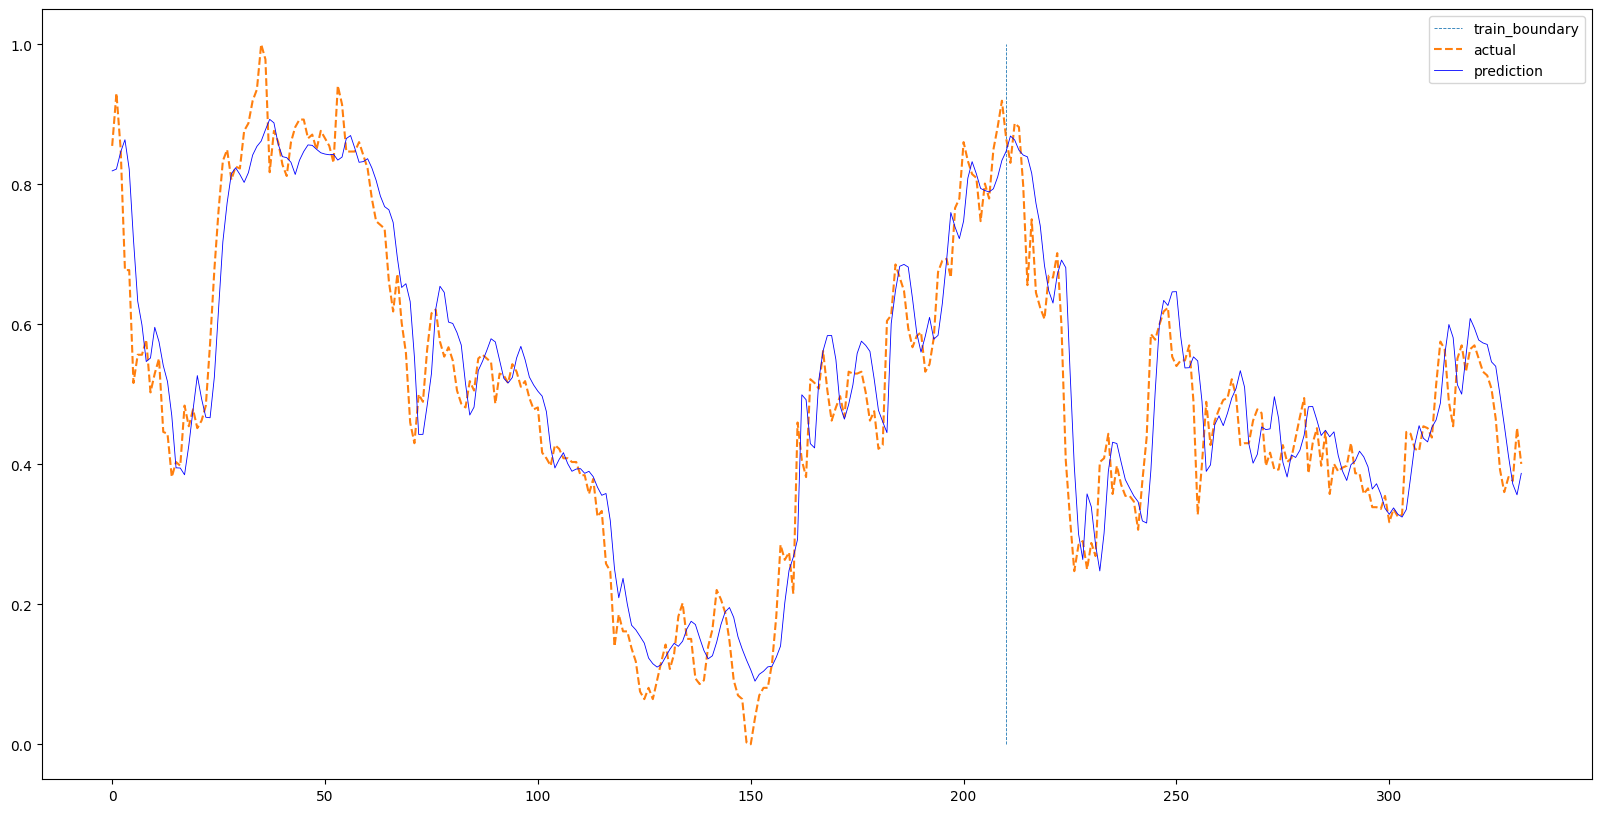

In [27]:
plt.figure(figsize = (20,10))
plt.plot(np.ones(100)*len(train), np.linspace(0,1,100), '--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred, 'b', linewidth = 0.6)
plt.legend(['train_boundary','actual','prediction'])
plt.show()

# LSTM
## 모델구축

In [28]:
#하이퍼 파라미터 정의
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [29]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(LSTM, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
    self.fc = nn.Linear(hidden_size*sequence_length ,1)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    c0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    out, _ = self.lstm(x,(h0,c0))
    out = out.reshape(out.shape[0], -1)
    out = self.fc(out)
    return out

In [30]:
model = LSTM(input_size = input_size,
             hidden_size=hidden_size,
             sequence_length=sequence_length,
             num_layers = num_layers,
             device=device).to(device)

In [31]:
criterion = nn.MSELoss()
num_epochs =50
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [32]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0

    for data in train_loader:

        seq, target = data # 배치 데이터
        out = model(seq)
        loss = criterion(out, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_graph.append(running_loss/n)
    if epoch % 10 == 0:
        print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))


[epoch: 0] loss: 0.1284
[epoch: 10] loss: 0.0093
[epoch: 20] loss: 0.0081
[epoch: 30] loss: 0.0071
[epoch: 40] loss: 0.0063


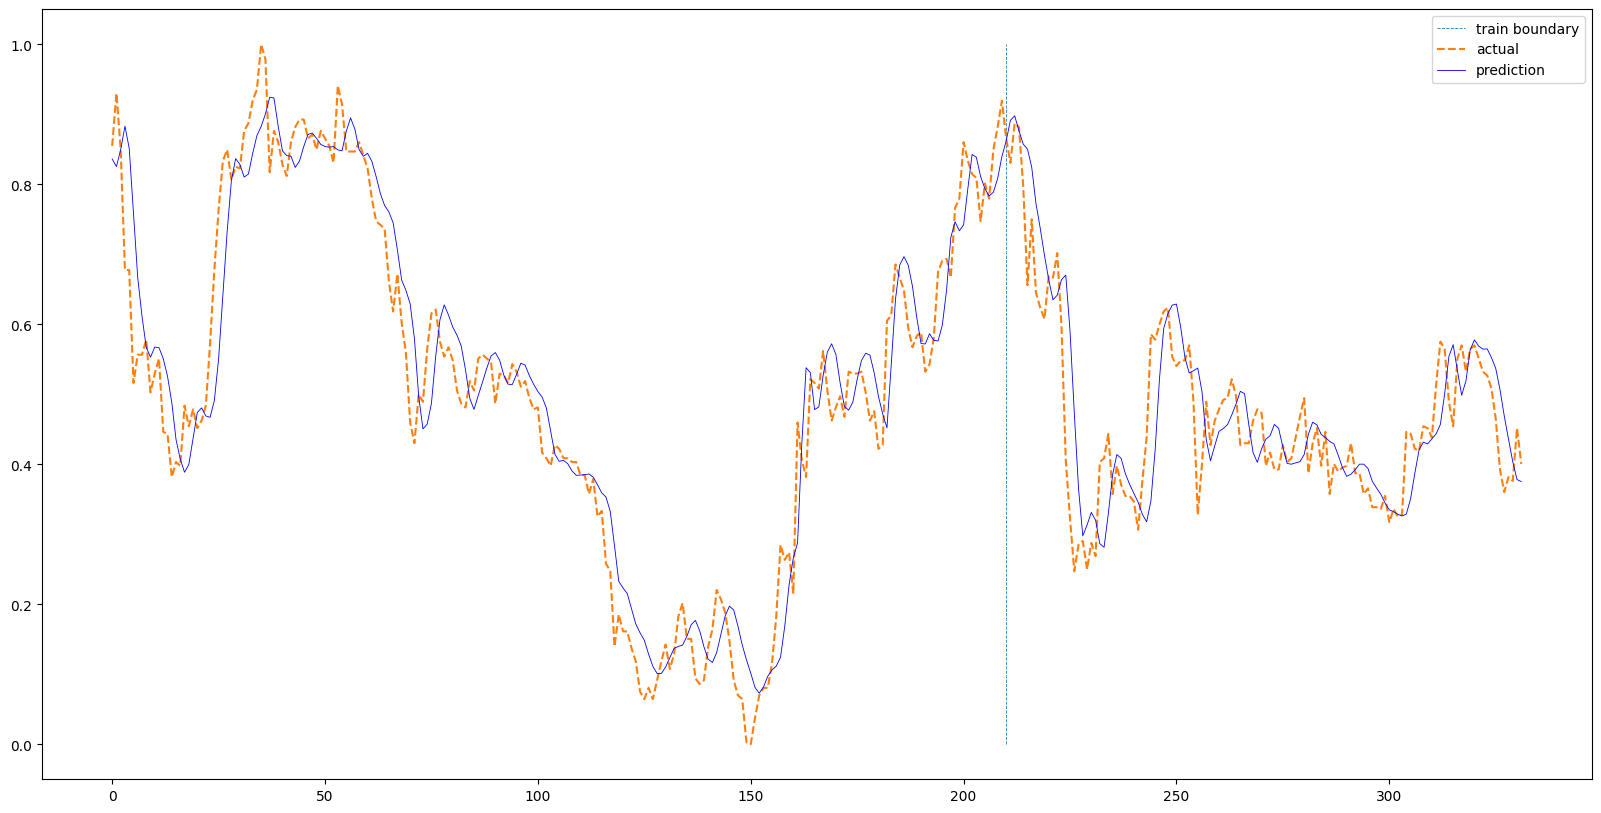

In [33]:
concatdata = torch.utils.data.ConcatDataset([train, test])
data_loader = torch.utils.data.DataLoader(dataset=concatdata, batch_size=100, shuffle=False)

with torch.no_grad():
    pred = []
    model.eval()
    for data in data_loader:
        seq, target = data
        out = model(seq)
        pred += out.cpu().tolist()

plt.figure(figsize=(20,10))
plt.plot(np.ones(100)*len(train),np.linspace(0,1,100),'--', linewidth=0.6)
plt.plot(df['Close'][sequence_length:].values,'--')
plt.plot(pred,'b', linewidth=0.6)
plt.legend(['train boundary','actual','prediction'])
plt.show()

**RNN: 비교적 간단한 순환구/장기의존성문제 --> 현재 상태만 기, 데이터가 많아질수록 이전 정보를 잘 기억하지 못함

**LSTM: RNN의 장기의존성 문제 해결, 단 복잡한 구조로 계산량이 많아 학습이 오래걸림


-> 지금은 RNN과 LSTM이 비슷한 예측을 하지만 데이터가 더 많아질 경우 LSTM이 더 유리할 수 있다.
